In [18]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [19]:
import os
import cv2
import numpy as np
import pandas as pd

# #Change this value based on your preferences
train_dir = "./jellyfish/Train_Test_Valid/Train"
train_dataframe = pd.DataFrame(columns=["path", "class"])

In [20]:
for class_name in os.listdir(train_dir):
  class_dir = os.path.join(train_dir, class_name)
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    train_dataframe.loc[len(train_dataframe.index)] = [image_path, class_name]

In [21]:
train_dataframe

,path,class
0,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
1,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
2,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
3,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
4,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
...,...,...
895,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
896,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
897,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
898,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish


In [22]:
xdim = 224
ydim = 224

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

main_datagen=ImageDataGenerator(rescale=1./255., # 정규화 
                               horizontal_flip = True, # 수평으로 뒤집기
                                vertical_flip = True, # 수직으로 뒤집기 
                               rotation_range = 5) # +5도 또는 -5도 범위 내에서 회전 

In [24]:
# 데이터프레임의 "path"라는 열의 데이터를 NumPy 배열로 변환하여 X에 담기 
X = np.array(train_dataframe["path"])

In [25]:
wandb.login(key = "c4e33984a0f1d0c7e209f455add7b4da4718e070")

#import os
#import wandb

#wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [26]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    #"method": "grid",  # Grid search
    "batch_size": {"values": [16, 32]},
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.01
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

def train_with_kfold():
    default_config = {
        "learning_rate": 0.005,
        "epoch": 5,
        "batch_size": 32
    }

    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    
    cvScores = []
    labels = list(train_dataframe["class"].unique())

    all_fold_histories = []  # 각 폴드별 기록 저장
    
    
    # W&B 실행 초기화 (Run 이름에서 폴드 정보 제외)
    wandb.init(
        config=default_config,
        project="WandB_with_kfold_used_by_Jindeok_revised",
        name=f"CrossValidation_{wandb.util.generate_id()}",
        reinit=True
    )
    config = wandb.config
    
    
    fold = 1
    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        print(f"Fold: {fold} ==================================================================")

        train_data = X[train_index]
        test_data = X[test_index]
        train_dataframe_inside = train_dataframe.loc[train_dataframe["path"].isin(list(train_data))]
        validation_dataframe = train_dataframe.loc[train_dataframe["path"].isin(list(test_data))]

        if train_dataframe_inside.empty or validation_dataframe.empty:
            print(f"Empty data detected in fold {fold}. Skipping.")
            continue

        train_generator = main_datagen.flow_from_dataframe(
            dataframe=train_dataframe_inside,
            x_col="path",
            y_col="class",
            class_mode="categorical",
            classes=labels,
            target_size=(xdim, ydim),
            color_mode="rgb",
            batch_size=32
        )

        validation_generator = main_datagen.flow_from_dataframe(
            dataframe=validation_dataframe,
            x_col="path",
            y_col="class",
            class_mode="categorical",
            classes=labels,
            target_size=(xdim, ydim),
            color_mode="rgb",
            batch_size=32
        )

       

        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(xdim, ydim, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(len(labels), activation='softmax')
        ])

    
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )

        model_history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=config.epoch,
            verbose=1,
            callbacks=[early_stopping]
        )

        # 각 폴드의 기록 저장
        all_fold_histories.append(model_history.history)
        
        
        # 폴드별 성능 로그
        scores = model.evaluate(validation_generator)
        cvScores.append(scores[1] * 100)
        print(f"Validation Accuracy for Fold {fold}: {scores[1] * 100:.2f}%")

        wandb.log({
            "fold": fold,
            "final_validation_accuracy": scores[1] * 100,
            "fold_train_accuracy": model_history.history["accuracy"][-1],
            "fold_val_accuracy": model_history.history["val_accuracy"][-1],
        })
        
        fold += 1 
        
        
    # 모든 폴드의 정확도 시각화
    plt.figure(figsize=(12, 8))
    for fold, history in enumerate(all_fold_histories, start=1):
        plt.plot(history['val_accuracy'], label=f'Fold {fold} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Across Folds')
    plt.legend()
    plt.show()
    
    
    
    # 평균 및 표준 편차 계산 및 출력
    mean_accuracy = np.mean(cvScores)
    std_accuracy = np.std(cvScores)
    print(f"Cross-validation scores: {cvScores}")
    print(f"Mean Accuracy: {mean_accuracy:.2f}%")
    print(f"Accuracy Standard Deviation: {std_accuracy:.2f}%")

    # 전체 결과 W&B 로그 추가
    wandb.log({
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy
    })
    
    wandb.finish()
    

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('batch_size' was unexpected)


Create sweep with ID: bck14rf9
Sweep URL: https://wandb.ai/wisdom-jihyekim-aiffel/WandB_with_kfold_used_by_Jindeok_revised/sweeps/bck14rf9


wandb: Agent Starting Run: acgtb5wj with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.004387873404325197
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/5
23/23 [==============================] - 10s 421ms/step - loss: 2.0509 - accuracy: 0.2292 - val_loss: 1.6517 - val_accuracy: 0.2889
Epoch 2/5
23/23 [==============================] - 9s 404ms/step - loss: 1.5562 - accuracy: 0.3556 - val_loss: 1.5573 - val_accuracy: 0.3667
Epoch 3/5
23/23 [==============================] - 9s 405ms/step - loss: 1.4509 - accuracy: 0.3875 - val_loss: 1.5521 - val_accuracy: 0.3833
Epoch 4/5
23/23 [==============================] - 9s 403ms/step - loss: 1.3955 - accuracy: 0.4181 - val_loss: 1.3529 - val_accuracy: 0.4556
Epoch 5/5
6/6 [==============================] - 2s 309ms/step - loss: 1.4349 - accuracy: 0.4333
Validation Accuracy for Fold 1: 43.33%
Fold: 2 ==================================================================
Found 720 validated image fil

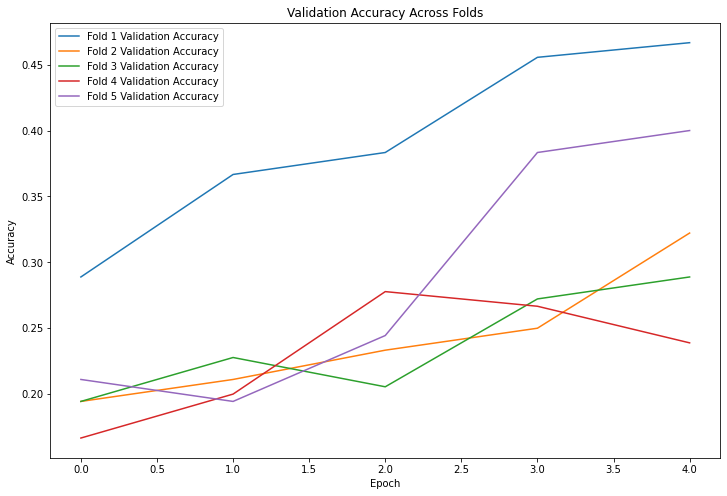

Cross-validation scores: [43.33333373069763, 28.888890147209167, 28.888890147209167, 25.555557012557983, 40.55555462837219]
Mean Accuracy: 33.44%
Accuracy Standard Deviation: 7.10%


final_validation_accuracy,█▂▂▁▇
fold,▁▃▅▆█
fold_train_accuracy,█▁▁▂▆
fold_val_accuracy,█▄▃▁▆
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,40.55555
fold,5
fold_train_accuracy,0.38333
fold_val_accuracy,0.4
mean_accuracy,33.44445


wandb: Agent Starting Run: x7iqk5f5 with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.007512467811043761
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/5
23/23 [==============================] - 11s 420ms/step - loss: 2.6446 - accuracy: 0.1694 - val_loss: 1.7855 - val_accuracy: 0.2056
Epoch 2/5
23/23 [==============================] - 10s 409ms/step - loss: 1.7799 - accuracy: 0.1917 - val_loss: 1.7716 - val_accuracy: 0.1556
Epoch 3/5
23/23 [==============================] - 9s 399ms/step - loss: 1.7463 - accuracy: 0.2125 - val_loss: 1.7595 - val_accuracy: 0.2111
Epoch 4/5
23/23 [==============================] - 9s 403ms/step - loss: 1.7443 - accuracy: 0.2125 - val_loss: 1.7570 - val_accuracy: 0.2056
Epoch 5/5
6/6 [==============================] - 2s 291ms/step - loss: 1.7598 - accuracy: 0.2056
Validation Accuracy for Fold 1: 20.56%
Fold: 2 ==================================================================
Found 720 validated image fi

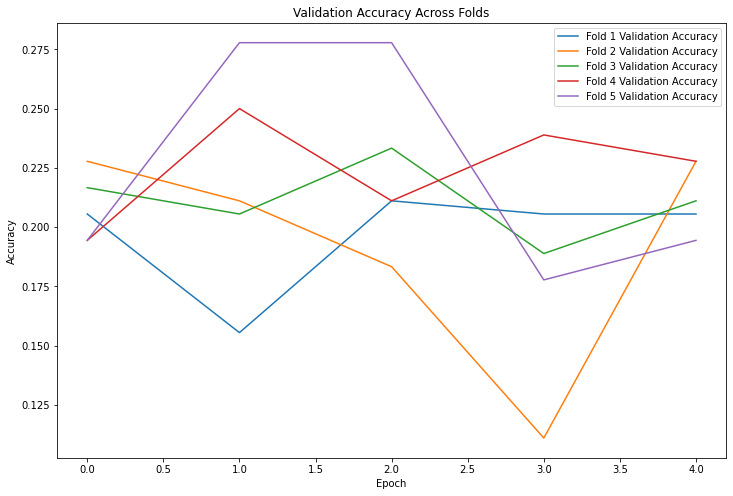

Cross-validation scores: [20.555555820465088, 22.777777910232544, 21.111111342906952, 22.22222238779068, 20.000000298023224]
Mean Accuracy: 21.33%
Accuracy Standard Deviation: 1.03%


final_validation_accuracy,▂█▄▇▁
fold,▁▃▅▆█
fold_train_accuracy,▅▂█▆▁
fold_val_accuracy,▃█▅█▁
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,20.0
fold,5
fold_train_accuracy,0.20278
fold_val_accuracy,0.19444
mean_accuracy,21.33333


wandb: Agent Starting Run: jep69rhw with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.007961877804558053
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/5
23/23 [==============================] - 11s 428ms/step - loss: 2.5988 - accuracy: 0.1681 - val_loss: 1.8654 - val_accuracy: 0.1778
Epoch 2/5
23/23 [==============================] - 9s 403ms/step - loss: 1.8432 - accuracy: 0.1792 - val_loss: 1.7937 - val_accuracy: 0.1667
Epoch 3/5
23/23 [==============================] - 9s 396ms/step - loss: 1.7960 - accuracy: 0.1722 - val_loss: 1.7907 - val_accuracy: 0.1889
Epoch 4/5
23/23 [==============================] - 9s 404ms/step - loss: 1.7925 - accuracy: 0.1611 - val_loss: 1.7919 - val_accuracy: 0.1889
Epoch 5/5
6/6 [==============================] - 2s 303ms/step - loss: 1.7926 - accuracy: 0.1389
Validation Accuracy for Fold 1: 13.89%
Fold: 2 ==================================================================
Found 720 validated image fil

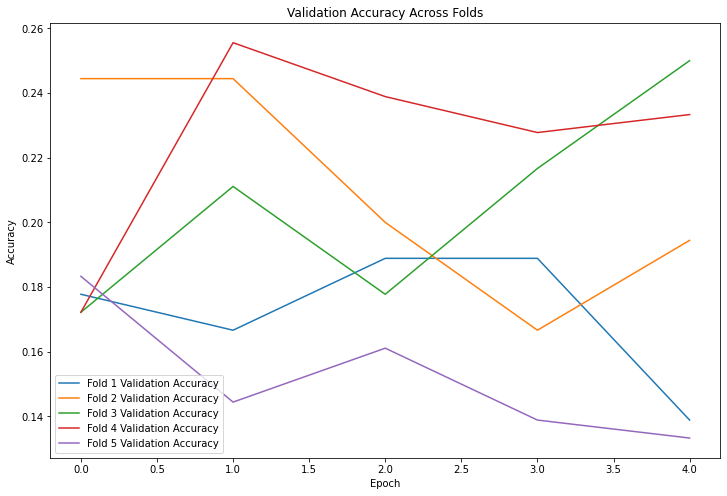

Cross-validation scores: [13.88888955116272, 19.44444477558136, 25.0, 23.888888955116272, 13.333334028720856]
Mean Accuracy: 19.11%
Accuracy Standard Deviation: 4.86%


final_validation_accuracy,▁▅█▇▁
fold,▁▃▅▆█
fold_train_accuracy,▂▃█▆▁
fold_val_accuracy,▁▅█▇▁
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,13.33333
fold,5
fold_train_accuracy,0.14583
fold_val_accuracy,0.13333
mean_accuracy,19.11111


wandb: Agent Starting Run: 7qc4lh8l with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.008513858663306763
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/10
23/23 [==============================] - 11s 423ms/step - loss: 2.8953 - accuracy: 0.1764 - val_loss: 1.8011 - val_accuracy: 0.2167
Epoch 2/10
23/23 [==============================] - 9s 403ms/step - loss: 1.8550 - accuracy: 0.1681 - val_loss: 1.7669 - val_accuracy: 0.1889
Epoch 3/10
23/23 [==============================] - 10s 420ms/step - loss: 1.7593 - accuracy: 0.2208 - val_loss: 1.8425 - val_accuracy: 0.2611
Epoch 4/10
23/23 [==============================] - 10s 414ms/step - loss: 1.7519 - accuracy: 0.2403 - val_loss: 1.7761 - val_accuracy: 0.2389
Epoch 5/10
23/23 [==============================] - 9s 401ms/step - loss: 1.7420 - accuracy: 0.2375 - val_loss: 1.7383 - val_accuracy: 0.2389
Epoch 6/10
23/23 [==============================] - 10s 409ms/step - loss: 1.7055 - accuracy

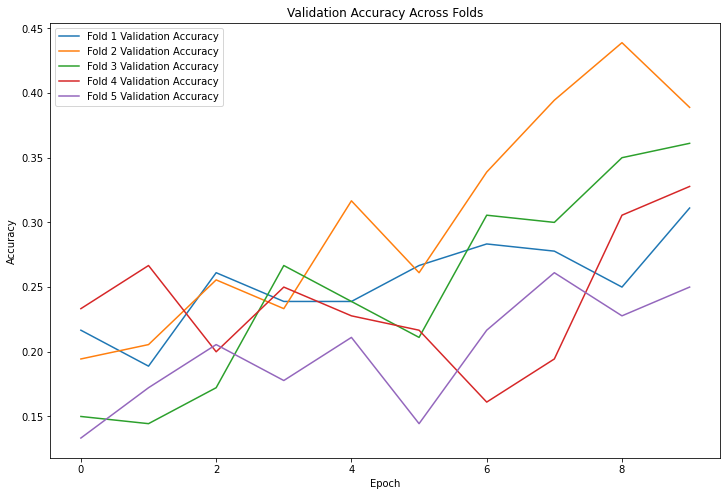

Cross-validation scores: [30.55555522441864, 40.55555462837219, 34.99999940395355, 32.777777314186096, 25.0]
Mean Accuracy: 32.78%
Accuracy Standard Deviation: 5.12%


final_validation_accuracy,▄█▆▅▁
fold,▁▃▅▆█
fold_train_accuracy,▃█▄▄▁
fold_val_accuracy,▄█▇▅▁
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,25.0
fold,5
fold_train_accuracy,0.26806
fold_val_accuracy,0.25
mean_accuracy,32.77778


wandb: Agent Starting Run: sqgdgbdf with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.0025836105224737666
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/9
23/23 [==============================] - 11s 426ms/step - loss: 2.2106 - accuracy: 0.2056 - val_loss: 1.7497 - val_accuracy: 0.2500
Epoch 2/9
23/23 [==============================] - 9s 398ms/step - loss: 1.6664 - accuracy: 0.2917 - val_loss: 1.6430 - val_accuracy: 0.3611
Epoch 3/9
23/23 [==============================] - 9s 400ms/step - loss: 1.4727 - accuracy: 0.3708 - val_loss: 1.5062 - val_accuracy: 0.4056
Epoch 4/9
23/23 [==============================] - 9s 406ms/step - loss: 1.4042 - accuracy: 0.4181 - val_loss: 1.4674 - val_accuracy: 0.4611
Epoch 5/9
23/23 [==============================] - 9s 400ms/step - loss: 1.3002 - accuracy: 0.4514 - val_loss: 1.3731 - val_accuracy: 0.4722
Epoch 6/9
23/23 [==============================] - 9s 401ms/step - loss: 1.1947 - accuracy: 0.5292 

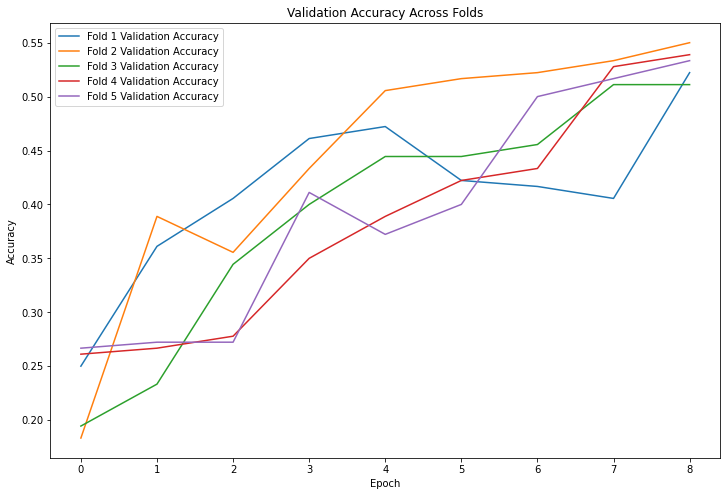

Cross-validation scores: [56.111109256744385, 58.33333134651184, 54.44444417953491, 53.33333611488342, 51.11111402511597]
Mean Accuracy: 54.67%
Accuracy Standard Deviation: 2.45%


final_validation_accuracy,▆█▄▃▁
fold,▁▃▅▆█
fold_train_accuracy,██▁▆▃
fold_val_accuracy,▃█▁▆▅
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,51.11111
fold,5
fold_train_accuracy,0.53472
fold_val_accuracy,0.53333
mean_accuracy,54.66667


wandb: Agent Starting Run: s9mw2wgj with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.007765493998079688
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/9
23/23 [==============================] - 11s 426ms/step - loss: 2.9332 - accuracy: 0.1764 - val_loss: 1.8389 - val_accuracy: 0.1611
Epoch 2/9
23/23 [==============================] - 9s 401ms/step - loss: 1.7699 - accuracy: 0.2194 - val_loss: 1.7690 - val_accuracy: 0.2111
Epoch 3/9
23/23 [==============================] - 9s 399ms/step - loss: 1.7551 - accuracy: 0.1736 - val_loss: 1.7619 - val_accuracy: 0.1833
Epoch 4/9
23/23 [==============================] - 9s 404ms/step - loss: 1.7505 - accuracy: 0.2000 - val_loss: 1.7431 - val_accuracy: 0.2167
Epoch 5/9
23/23 [==============================] - 9s 402ms/step - loss: 1.7384 - accuracy: 0.2278 - val_loss: 1.7428 - val_accuracy: 0.2833
Epoch 6/9
23/23 [==============================] - 9s 398ms/step - loss: 1.7193 - accuracy: 0.2528 

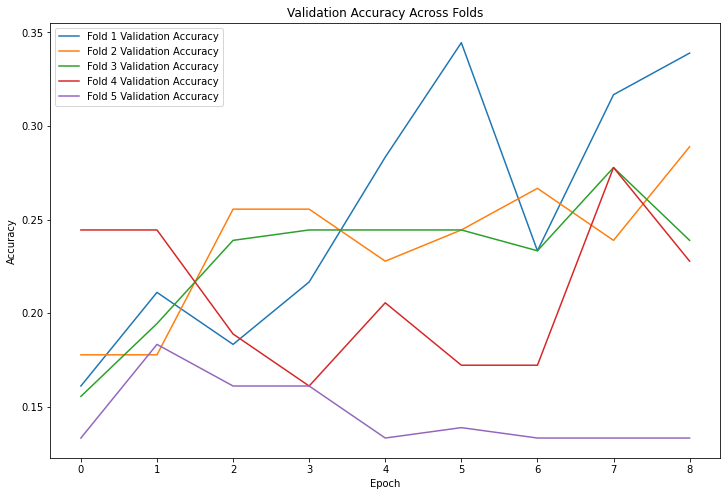

Cross-validation scores: [32.777777314186096, 28.333333134651184, 25.555557012557983, 21.666666865348816, 13.333334028720856]
Mean Accuracy: 24.33%
Accuracy Standard Deviation: 6.59%


final_validation_accuracy,█▆▅▄▁
fold,▁▃▅▆█
fold_train_accuracy,█▆▇▅▁
fold_val_accuracy,█▆▅▄▁
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,13.33333
fold,5
fold_train_accuracy,0.175
fold_val_accuracy,0.13333
mean_accuracy,24.33333


wandb: Agent Starting Run: st0w0b6q with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.0078940011027272
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/9
23/23 [==============================] - 11s 431ms/step - loss: 3.1029 - accuracy: 0.1472 - val_loss: 1.9469 - val_accuracy: 0.2333
Epoch 2/9
23/23 [==============================] - 9s 406ms/step - loss: 1.8168 - accuracy: 0.1917 - val_loss: 1.7793 - val_accuracy: 0.1944
Epoch 3/9
23/23 [==============================] - 9s 392ms/step - loss: 1.7643 - accuracy: 0.1722 - val_loss: 1.7661 - val_accuracy: 0.2056
Epoch 4/9
23/23 [==============================] - 9s 402ms/step - loss: 1.7421 - accuracy: 0.2028 - val_loss: 1.7646 - val_accuracy: 0.1944
Epoch 5/9
23/23 [==============================] - 9s 404ms/step - loss: 1.7429 - accuracy: 0.2250 - val_loss: 1.7742 - val_accuracy: 0.2000
Epoch 6/9
23/23 [==============================] - 9s 402ms/step - loss: 1.7232 - accuracy: 0.2181 

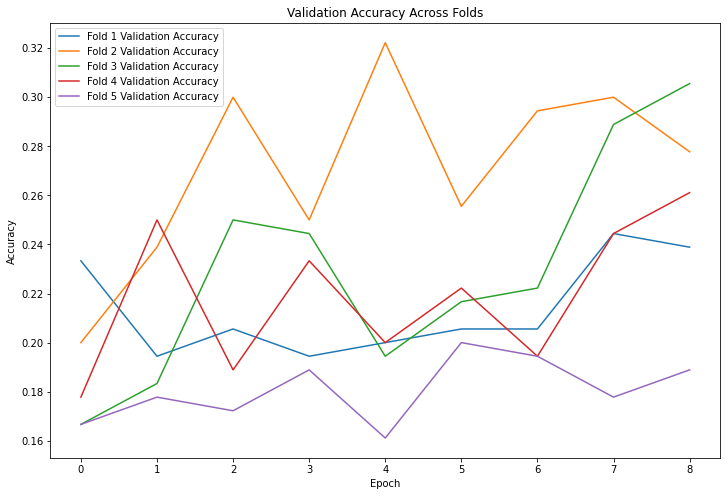

Cross-validation scores: [23.333333432674408, 26.111111044883728, 31.666666269302368, 26.111111044883728, 18.888889253139496]
Mean Accuracy: 25.22%
Accuracy Standard Deviation: 4.17%


final_validation_accuracy,▃▅█▅▁
fold,▁▃▅▆█
fold_train_accuracy,▅██▁▁
fold_val_accuracy,▄▆█▅▁
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,18.88889
fold,5
fold_train_accuracy,0.22639
fold_val_accuracy,0.18889
mean_accuracy,25.22222


wandb: Agent Starting Run: w9f0wlu1 with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.004725321057482983
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/8
23/23 [==============================] - 11s 421ms/step - loss: 2.3767 - accuracy: 0.1861 - val_loss: 1.8493 - val_accuracy: 0.1778
Epoch 2/8
23/23 [==============================] - 9s 395ms/step - loss: 1.8063 - accuracy: 0.1875 - val_loss: 1.8802 - val_accuracy: 0.1778
Epoch 3/8
23/23 [==============================] - 9s 401ms/step - loss: 1.7889 - accuracy: 0.2042 - val_loss: 1.8093 - val_accuracy: 0.2278
Epoch 4/8
23/23 [==============================] - 9s 401ms/step - loss: 1.7353 - accuracy: 0.2306 - val_loss: 1.7349 - val_accuracy: 0.2278
Epoch 5/8
23/23 [==============================] - 9s 396ms/step - loss: 1.6868 - accuracy: 0.2958 - val_loss: 1.6550 - val_accuracy: 0.3111
Epoch 6/8
23/23 [==============================] - 9s 401ms/step - loss: 1.5781 - accuracy: 0.3306 

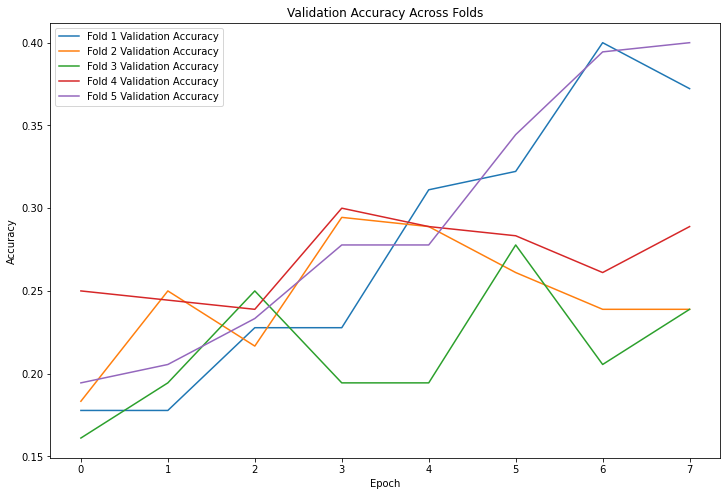

Cross-validation scores: [37.22222149372101, 22.22222238779068, 25.0, 26.66666805744171, 37.22222149372101]
Mean Accuracy: 29.67%
Accuracy Standard Deviation: 6.33%


final_validation_accuracy,█▁▂▃█
fold,▁▃▅▆█
fold_train_accuracy,█▁▁▁▇
fold_val_accuracy,▇▁▁▃█
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,37.22222
fold,5
fold_train_accuracy,0.39583
fold_val_accuracy,0.4
mean_accuracy,29.66667


wandb: Agent Starting Run: b1uvr39s with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.009509027453974936
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/10
23/23 [==============================] - 10s 420ms/step - loss: 3.1374 - accuracy: 0.1917 - val_loss: 1.8049 - val_accuracy: 0.1889
Epoch 2/10
23/23 [==============================] - 9s 396ms/step - loss: 1.8045 - accuracy: 0.1736 - val_loss: 1.7545 - val_accuracy: 0.1667
Epoch 3/10
23/23 [==============================] - 9s 395ms/step - loss: 1.7776 - accuracy: 0.1875 - val_loss: 1.8178 - val_accuracy: 0.2056
Epoch 4/10
23/23 [==============================] - 9s 407ms/step - loss: 1.7621 - accuracy: 0.2042 - val_loss: 1.7603 - val_accuracy: 0.1889
Epoch 5/10
23/23 [==============================] - 9s 394ms/step - loss: 1.7375 - accuracy: 0.2153 - val_loss: 1.7602 - val_accuracy: 0.2000
Epoch 6/10
23/23 [==============================] - 9s 396ms/step - loss: 1.7349 - accuracy: 0

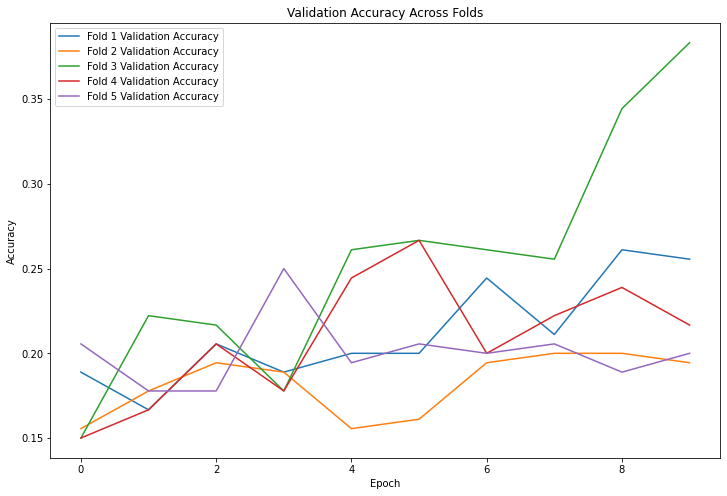

Cross-validation scores: [26.66666805744171, 20.000000298023224, 40.00000059604645, 21.666666865348816, 19.44444477558136]
Mean Accuracy: 25.56%
Accuracy Standard Deviation: 7.66%


final_validation_accuracy,▃▁█▂▁
fold,▁▃▅▆█
fold_train_accuracy,▅▁▇█▃
fold_val_accuracy,▃▁█▂▁
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,19.44444
fold,5
fold_train_accuracy,0.22222
fold_val_accuracy,0.2
mean_accuracy,25.55556


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 085uxunn with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.002104920270078526
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/5
23/23 [==============================] - 10s 419ms/step - loss: 2.0740 - accuracy: 0.2042 - val_loss: 1.7835 - val_accuracy: 0.2000
Epoch 2/5
23/23 [==============================] - 9s 400ms/step - loss: 1.7472 - accuracy: 0.2264 - val_loss: 1.7294 - val_accuracy: 0.2389
Epoch 3/5
23/23 [==============================] - 9s 399ms/step - loss: 1.7165 - accuracy: 0.2375 - val_loss: 1.6847 - val_accuracy: 0.3000
Epoch 4/5
23/23 [==============================] - 9s 404ms/step - loss: 1.5991 - accuracy: 0.3208 - val_loss: 1.5774 - val_accuracy: 0.3389
Epoch 5/5
6/6 [==============================] - 2s 298ms/step - loss: 1.4507 - accuracy: 0.3611
Validation Accuracy for Fold 1: 36.11%
Fold: 2 ==================================================================
Found 720 validated image fil

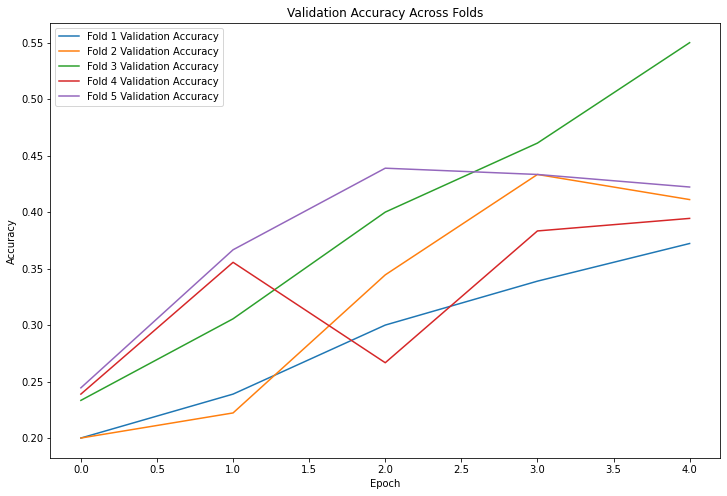

Cross-validation scores: [36.11111044883728, 40.55555462837219, 57.22222328186035, 41.66666567325592, 41.111111640930176]
Mean Accuracy: 43.33%
Accuracy Standard Deviation: 7.22%


final_validation_accuracy,▁▂█▃▃
fold,▁▃▅▆█
fold_train_accuracy,▁▅▄▅█
fold_val_accuracy,▁▃█▂▃
mean_accuracy,▁
std_accuracy,▁
final_validation_accuracy,41.11111
fold,5
fold_train_accuracy,0.48611
fold_val_accuracy,0.42222
mean_accuracy,43.33333


In [28]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "wisdom-jihyekim-aiffel",
                       project = "WandB_with_kfold_used_by_Jindeok_revised")


# run the sweep
wandb.agent(sweep_id,
            function=train_with_kfold,
            count=10)


W&B Run Performance Comparison:
      Run ID                  Run Name  Mean Accuracy  Std Accuracy  \
14  rib38n5y  CrossValidation_dpmu9wft      62.000000      1.632993   
17  ke6xjvi1  CrossValidation_w5f312sl      61.555555      3.691834   
16  g3bx2wds  CrossValidation_60d3e859      56.777779      3.284831   
5   sqgdgbdf  CrossValidation_qoamoxa2      54.666667      2.449488   
15  3alw88x3  CrossValidation_0ncop46c      48.777778      6.539528   
18  7mnehmt3  CrossValidation_34fs90jc      45.222222      1.742709   
0   085uxunn  CrossValidation_2d3vyofo      43.333333      7.217948   
13  ai6vbpmg  CrossValidation_edd95r4e      34.000000      5.344895   
10  c6ruhtcc  CrossValidation_il2zhp8j      34.000000      8.038488   
9   acgtb5wj  CrossValidation_qvuy7vy9      33.444445      7.100686   
6   7qc4lh8l  CrossValidation_qq194zhf      32.777777      5.115939   
12  bl8wlexo  CrossValidation_cwipkapz      31.888889      4.838120   
2   w9f0wlu1  CrossValidation_2016wttj      

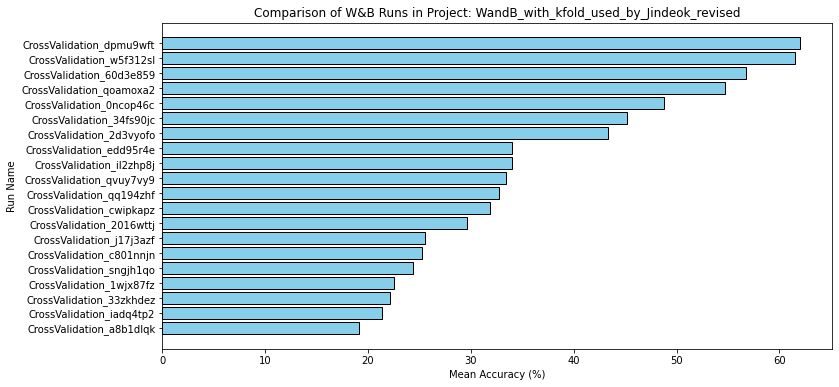

In [29]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def compare_wandb_runs(project_name):
    # W&B API를 사용해 프로젝트의 모든 Runs 정보 가져오기
    api = wandb.Api()
    runs = api.runs(project_name)

    # 데이터를 저장할 리스트
    data = []
    
    for run in runs:
        # 필요한 메트릭 추출 (mean_accuracy, std_accuracy 등)
        mean_accuracy = run.summary.get("mean_accuracy", None)
        std_accuracy = run.summary.get("std_accuracy", None)
        final_val_accuracy = run.summary.get("final_validation_accuracy", None)
        run_id = run.id
        run_name = run.name

        # 메트릭 값이 None이거나 문자열인 경우, NaN으로 처리
        try:
            mean_accuracy = float(mean_accuracy) if mean_accuracy is not None else np.nan
            std_accuracy = float(std_accuracy) if std_accuracy is not None else np.nan
            final_val_accuracy = float(final_val_accuracy) if final_val_accuracy is not None else np.nan
        except ValueError:
            mean_accuracy = np.nan
            std_accuracy = np.nan
            final_val_accuracy = np.nan

        # 리스트에 추가
        data.append({
            "Run ID": run_id,
            "Run Name": run_name,
            "Mean Accuracy": mean_accuracy,
            "Std Accuracy": std_accuracy,
            "Final Validation Accuracy": final_val_accuracy
        })

    # DataFrame으로 변환
    df = pd.DataFrame(data)

    # NaN 값 제거
    df = df.dropna(subset=["Mean Accuracy"])

    # 데이터프레임 정렬 (기본: Mean Accuracy 기준 내림차순)
    df = df.sort_values(by="Mean Accuracy", ascending=False)

    print("\nW&B Run Performance Comparison:")
    print(df)

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.barh(df["Run Name"], df["Mean Accuracy"], color="skyblue", edgecolor="black")
    plt.xlabel("Mean Accuracy (%)")
    plt.ylabel("Run Name")
    plt.title(f"Comparison of W&B Runs in Project: {project_name}")
    plt.gca().invert_yaxis()  # 가장 높은 성능이 상단에 오도록 설정
    plt.show()

    return df

# 사용 예시
project_name = "WandB_with_kfold_used_by_Jindeok_revised"  # 비교하려는 W&B 프로젝트 이름
comparison_df = compare_wandb_runs(project_name)
